<a href="https://colab.research.google.com/github/mahesh-babu-chittem/Machine-Learning-MaheshBabuChittem/blob/main/Lab7_AP23110010084_KNN(ScrathVersion%26SklearnVersion_WithoutMissingValues).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup & download + imports**

In [ ]:
# If gdown not installed, uncomment the next line:
# !pip install --upgrade gdown

# Download dataset (your shared file id)
!gdown --id 1ZdhRqYv-JizWV6DxO6C4R_k1kxPhmlF2 -O groceries.csv

# Imports
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
%matplotlib inline

print("Setup complete. File saved as groceries.csv")

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ZdhRqYv-JizWV6DxO6C4R_k1kxPhmlF2
To: /content/groceries.csv
100% 14.6k/14.6k [00:00<00:00, 3.06MB/s]
Setup complete. File saved as groceries.csv


In [ ]:
# Show missing values before KNN imputation
print("Missing values per column (BEFORE KNN imputation):")
print(X_df.isna().sum())

print("\nNOTE — what to record:")
print("- Copy the missing-value counts above (BEFORE imputation).")


Missing values per column (BEFORE KNN imputation):
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

NOTE — what to record:
- Copy the missing-value counts above (BEFORE imputation).


**Inspect dataset (shape, head, dtypes, missing) — record basic facts**

In [ ]:
df = pd.read_csv('groceries.csv')
print("=== SHAPE ===")
print(df.shape)

print("\n=== HEAD (first 10 rows) ===")
display(df.head(10))

print("\n=== DTYPES ===")
print(df.dtypes)

print("\n=== MISSING VALUES PER COLUMN ===")
print(df.isna().sum())

# Determine target column automatically if possible
possible_targets = [c for c in df.columns if c.lower() in ('target','label','class','category','categoryname')]
if possible_targets:
    suggested_target = possible_targets[0]
    print(f"\nDetected likely target column: '{suggested_target}' (one of {possible_targets})")
else:
    suggested_target = df.columns[-1]
    print(f"\nNo common target name detected. Defaulting to last column as TARGET: '{suggested_target}'.")
    print("If this is incorrect, change TARGET variable in the next cell.")

print("- Dataset shape (rows, columns):", df.shape)
print("- Columns list (copy them):", list(df.columns))
print("- Suggested target column to inspect:", suggested_target)
print("- Any nonzero missing counts per column (copy exact numbers above).")

=== SHAPE ===
(440, 8)

=== HEAD (first 10 rows) ===


,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,class
0,3,12669,9656,7561,214,2674,1338,2
1,3,7057,9810,9568,1762,3293,1776,2
2,3,6353,8808,7684,2405,3516,7844,2
3,3,13265,1196,4221,6404,507,1788,1
4,3,22615,5410,7198,3915,1777,5185,1
5,3,9413,8259,5126,666,1795,1451,3
6,3,12126,3199,6975,480,3140,545,3
7,3,7579,4956,9426,1669,3321,2566,2
8,3,5963,3648,6192,425,1716,750,3
9,3,6006,11093,18881,1159,7425,2098,2



=== DTYPES ===
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
class               int64
dtype: object

=== MISSING VALUES PER COLUMN ===
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
class               0
dtype: int64

Detected likely target column: 'class' (one of ['class'])
- Dataset shape (rows, columns): (440, 8)
- Columns list (copy them): ['Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen', 'class']
- Suggested target column to inspect: class
- Any nonzero missing counts per column (copy exact numbers above).


**Set TARGET, separate X/y, report target distribution (you can change TARGET if wrong)**

In [ ]:
# If the suggested column is wrong, change TARGET to the correct column name here:
TARGET = None  # <<== If this is None, we auto-use suggestion from previous cell.

# Auto-suggestion fallback:
if TARGET is None:
    # reuse df detection from previous cell
    possible_targets = [c for c in df.columns if c.lower() in ('target','label','class','category','categoryname')]
    TARGET = possible_targets[0] if possible_targets else df.columns[-1]

print("Using TARGET column:", TARGET)
if TARGET not in df.columns:
    raise SystemExit(f"ERROR: TARGET '{TARGET}' not found in dataframe columns. Please set TARGET to a valid column name and re-run this cell.")

X_df = df.drop(columns=[TARGET]).copy()
y_series = df[TARGET].copy()

print("\nFeatures shape:", X_df.shape)
print("Target (y) sample values and counts:")
display(y_series.value_counts().head(20))

print("- Confirmed TARGET column name:", TARGET)
print("- Number of features (columns after dropping target):", X_df.shape[1])
print("- Target class counts (copy exact counts shown above).")

Using TARGET column: class

Features shape: (440, 7)
Target (y) sample values and counts:


,count
class,
2,180
3,173
1,87


- Confirmed TARGET column name: class
- Number of features (columns after dropping target): 7
- Target class counts (copy exact counts shown above).


**Fill missing values & record what changed**

In [ ]:
# Fill missing values: numeric -> mean, categorical -> mode
num_cols = X_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_df.select_dtypes(include=['object','category']).columns.tolist()

before_missing = X_df.isna().sum()
print("Missing before filling (per column):")
print(before_missing[before_missing > 0])

# Fill
for c in num_cols:
    if X_df[c].isna().sum() > 0:
        X_df[c].fillna(X_df[c].mean(), inplace=True)
for c in cat_cols:
    if X_df[c].isna().sum() > 0:
        mode_val = X_df[c].mode().iloc[0] if not X_df[c].mode().empty else "missing"
        X_df[c].fillna(mode_val, inplace=True)

after_missing = X_df.isna().sum()
print("\nMissing after filling (per column):")
print(after_missing[after_missing > 0])

print("\nNOTE — what to record:")
print("- Missing values per column BEFORE filling (copy the table above).")
print("- Missing values per column AFTER filling (should be zero for handled columns).")
print("- Imputation strategy: numeric->mean, categorical->mode.")

Missing before filling (per column):
Series([], dtype: int64)

Missing after filling (per column):
Series([], dtype: int64)

NOTE — what to record:
- Missing values per column BEFORE filling (copy the table above).
- Missing values per column AFTER filling (should be zero for handled columns).
- Imputation strategy: numeric->mean, categorical->mode.


**Encode categorical features & scale — show mappings and scaled stats (record)**

In [ ]:
# Label-encode categorical features for simplicity (we'll list mappings)
encoders = {}
cat_mappings = {}
for c in cat_cols:
    le = LabelEncoder()
    X_df[c] = le.fit_transform(X_df[c].astype(str))
    encoders[c] = le
    cat_mappings[c] = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"Column '{c}' mapping (first 20):", list(cat_mappings[c].items())[:20])

# Encode target if needed
target_encoder = None
if y_series.dtype == 'object' or y_series.dtype.name == 'category':
    target_encoder = LabelEncoder()
    y = target_encoder.fit_transform(y_series.astype(str))
    print("\nTarget encoded. Mapping (class_label -> int):")
    print(dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_))))
else:
    y = y_series.values.copy()
    print("\nTarget numeric; no encoding applied.")

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X_df.values)

# Quick scaled stats (should have mean approx 0 and std ~1 per feature)
means = X.mean(axis=0)
stds  = X.std(axis=0)
print("\nScaled feature means (first 10):", np.round(means[:10], 4))
print("Scaled feature stds (first 10):", np.round(stds[:10], 4))

print("- Categorical columns label-encoded and their mappings (copy mappings printed above).")
if target_encoder is not None:
    print("- Target mapping (copy printed mapping).")
print("- Scaling used: StandardScaler. Check that feature means ~0 and std ~1 (copy the first 10 means/stds above).")


Target numeric; no encoding applied.

Scaled feature means (first 10): [ 0. -0.  0. -0.  0.  0. -0.]
Scaled feature stds (first 10): [1. 1. 1. 1. 1. 1. 1.]
- Categorical columns label-encoded and their mappings (copy mappings printed above).
- Scaling used: StandardScaler. Check that feature means ~0 and std ~1 (copy the first 10 means/stds above).


**Train / Test split (ensure arrays, record sizes & class balance)**

In [ ]:
# Split
stratify_val = y if len(np.unique(y))>1 else None
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=stratify_val)

# Convert to numpy arrays explicitly
X_train = np.asarray(X_train); X_test = np.asarray(X_test)
y_train = np.asarray(y_train); y_test = np.asarray(y_test)

print("Train shape X, y:", X_train.shape, y_train.shape)
print("Test shape  X, y:", X_test.shape, y_test.shape)

from collections import Counter
print("\nTrain label counts:", Counter(y_train))
print("Test label counts: ", Counter(y_test))

print("- Number of training samples:", X_train.shape[0])
print("- Number of test samples:", X_test.shape[0])
print("- Train label counts (copy the dict above).")
print("- Test label counts  (copy the dict above).")


Train shape X, y: (330, 7) (330,)
Test shape  X, y: (110, 7) (110,)

Train label counts: Counter({np.int64(2): 135, np.int64(3): 130, np.int64(1): 65})
Test label counts:  Counter({np.int64(2): 45, np.int64(3): 43, np.int64(1): 22})
- Number of training samples: 330
- Number of test samples: 110
- Train label counts (copy the dict above).
- Test label counts  (copy the dict above).


**Scratch KNN Step A: Implement distance calculation + single test example demo (print details you must record)**

In [ ]:
# We'll demo distances for 1 test example to illustrate step A and B.
test_idx_demo = 0   # index within X_test to inspect; change if you want another
print(f"Demonstration test sample (index in X_test): {test_idx_demo}")

# Compute distances from this single test point to all training points
test_point = X_test[test_idx_demo]
dists_all = np.linalg.norm(X_train - test_point, axis=1)

# Show top 10 smallest distances
sorted_idx = np.argsort(dists_all)
top_k = 10
top_idxs = sorted_idx[:top_k]
top_dists = dists_all[top_idxs]
top_labels = y_train[top_idxs]

print("\nTop 10 nearest training points (index in X_train) and distances and labels:")
for rank, (idx, dist, lab) in enumerate(zip(top_idxs, top_dists, top_labels), start=1):
    print(f"{rank:2d}. train_idx={idx:4d}  distance={dist:.6f}  label={lab}")

print("\nEXPLICIT STEPS SHOWN:")
print("Step 1: Choose k (we will choose k later).")
print("Step 2a: Distances computed for this test example to all training examples above.")
print("Step 2b: Sorted distances and listed top 10 neighbors above.")

print("- test_idx_demo (index in X_test):", test_idx_demo)
print("- For top 10 neighbors: list of (train_idx, distance, label) — copy the 10 rows printed above.")


Demonstration test sample (index in X_test): 0

Top 10 nearest training points (index in X_train) and distances and labels:
 1. train_idx=  98  distance=0.165257  label=3
 2. train_idx=  53  distance=0.287649  label=3
 3. train_idx= 276  distance=0.296552  label=3
 4. train_idx= 198  distance=0.299878  label=3
 5. train_idx= 309  distance=0.311213  label=3
 6. train_idx= 296  distance=0.333146  label=3
 7. train_idx= 194  distance=0.354221  label=3
 8. train_idx= 315  distance=0.368381  label=3
 9. train_idx= 240  distance=0.379235  label=3
10. train_idx= 304  distance=0.397220  label=3

EXPLICIT STEPS SHOWN:
Step 1: Choose k (we will choose k later).
Step 2a: Distances computed for this test example to all training examples above.
Step 2b: Sorted distances and listed top 10 neighbors above.
- test_idx_demo (index in X_test): 0
- For top 10 neighbors: list of (train_idx, distance, label) — copy the 10 rows printed above.


**Scratch KNN Step B: Implement neighbor selection, majority & weighted voting on single test example (prints decisions)**

In [ ]:
# We'll use the same test_idx_demo from previous cell
test_idx_demo = 0
test_point = X_test[test_idx_demo]
dists_all = np.linalg.norm(X_train - test_point, axis=1)
sorted_idx = np.argsort(dists_all)

# Choose k for this demo
k_demo = 5
idxs_k = sorted_idx[:k_demo]
dists_k = dists_all[idxs_k]
labels_k = y_train[idxs_k]

print(f"Using k = {k_demo} for this demo test point (index in X_test: {test_idx_demo})")
print("\nNeighbors (ranked 1..k):")
for i, (idx, d, lab) in enumerate(zip(idxs_k, dists_k, labels_k), start=1):
    print(f"{i}. train_idx={idx} distance={d:.6f} label={lab}")

# Majority vote
def majority_vote(neigh_labels):
    c = Counter(neigh_labels)
    most_common = c.most_common()
    top_count = most_common[0][1]
    top_labels = [lab for lab,cnt in most_common if cnt == top_count]
    if len(top_labels) == 1:
        return most_common[0][0]
    else:
        # tie -> choose label of nearest neighbor among k
        return neigh_labels[0]

def weighted_vote(neigh_labels, neigh_dists, eps=1e-8):
    weights = {}
    for lab, d in zip(neigh_labels, neigh_dists):
        w = 1.0/(d + eps)
        weights[lab] = weights.get(lab, 0) + w
    return max(weights.items(), key=lambda x: x[1])[0]

maj_pred = majority_vote(labels_k)
wgt_pred = weighted_vote(labels_k, dists_k)

print("\nPredictions for this test point:")
print("- Majority vote prediction:", maj_pred)
print("- Weighted (1/distance) prediction:", wgt_pred)
print("- True label:", y_test[test_idx_demo])

print("- k used:", k_demo)
print("- Neighbor list (train_idx, distance, label) (copy above).")
print("- Majority vote predicted label:", maj_pred)
print("- Weighted vote predicted label:", wgt_pred)
print("- True label of test point:", y_test[test_idx_demo])


Using k = 5 for this demo test point (index in X_test: 0)

Neighbors (ranked 1..k):
1. train_idx=98 distance=0.165257 label=3
2. train_idx=53 distance=0.287649 label=3
3. train_idx=276 distance=0.296552 label=3
4. train_idx=198 distance=0.299878 label=3
5. train_idx=309 distance=0.311213 label=3

Predictions for this test point:
- Majority vote prediction: 3
- Weighted (1/distance) prediction: 3
- True label: 3
- k used: 5
- Neighbor list (train_idx, distance, label) (copy above).
- Majority vote predicted label: 3
- Weighted vote predicted label: 3
- True label of test point: 3


**Scratch KNN Step C: Full prediction function (split cell) and test on entire test set — print global metrics + what to record**

In [ ]:
# Full scratch KNN predictor function (uses numpy arrays)
def scratch_knn_predict_full(X_train_local, y_train_local, X_test_local, k=3, use_weighted=False):
    preds = []
    for i in range(X_test_local.shape[0]):
        dists = np.linalg.norm(X_train_local - X_test_local[i], axis=1)
        idxs = np.argsort(dists)[:k]
        neigh_labels = y_train_local[idxs]
        neigh_dists  = dists[idxs]
        if use_weighted:
            # weighted vote
            weights = {}
            for lab, d in zip(neigh_labels, neigh_dists):
                w = 1.0/(d + 1e-8)
                weights[lab] = weights.get(lab, 0) + w
            pred = max(weights.items(), key=lambda x: x[1])[0]
        else:
            # majority vote with nearest-neighbor tie break
            c = Counter(neigh_labels)
            most_common = c.most_common()
            top_count = most_common[0][1]
            top_labels = [lab for lab,cnt in most_common if cnt == top_count]
            if len(top_labels) == 1:
                pred = most_common[0][0]
            else:
                pred = neigh_labels[0]
        preds.append(pred)
    return np.array(preds)

# Run scratch KNN on the full test set for k=5 (unweighted)
k_full = 5
y_pred_scratch = scratch_knn_predict_full(X_train, y_train, X_test, k=k_full, use_weighted=False)

acc_scratch = accuracy_score(y_test, y_pred_scratch)
cm_scratch  = confusion_matrix(y_test, y_pred_scratch)
report_scratch = classification_report(y_test, y_pred_scratch, output_dict=False)

print(f"Scratch KNN (unweighted) on entire test set with k={k_full}")
print("Accuracy:", acc_scratch)
print("\nConfusion Matrix:\n", cm_scratch)
print("\nClassification Report:\n", report_scratch)

print("- k used:", k_full)
print("- Test set accuracy (scratch KNN):", acc_scratch)
print("- Confusion matrix (copy the matrix printed above).")
print("- Classification report (copy precision/recall/F1 rows above).")


Scratch KNN (unweighted) on entire test set with k=5
Accuracy: 0.9272727272727272

Confusion Matrix:
 [[18  0  4]
 [ 2 42  1]
 [ 0  1 42]]

Classification Report:
               precision    recall  f1-score   support

           1       0.90      0.82      0.86        22
           2       0.98      0.93      0.95        45
           3       0.89      0.98      0.93        43

    accuracy                           0.93       110
   macro avg       0.92      0.91      0.92       110
weighted avg       0.93      0.93      0.93       110

- k used: 5
- Test set accuracy (scratch KNN): 0.9272727272727272
- Confusion matrix (copy the matrix printed above).
- Classification report (copy precision/recall/F1 rows above).


**Scratch KNN Step D: Try different k values (k sweep) and print list + best k (record)**

k, accuracy
 1 , 0.872727
 3 , 0.945455
 5 , 0.927273
 7 , 0.900000
 9 , 0.909091
11 , 0.900000
13 , 0.900000
15 , 0.918182
17 , 0.909091
19 , 0.909091
21 , 0.890909
23 , 0.890909
25 , 0.890909
27 , 0.890909
29 , 0.854545

Best k from tested odd values: k=3 with accuracy=0.945455


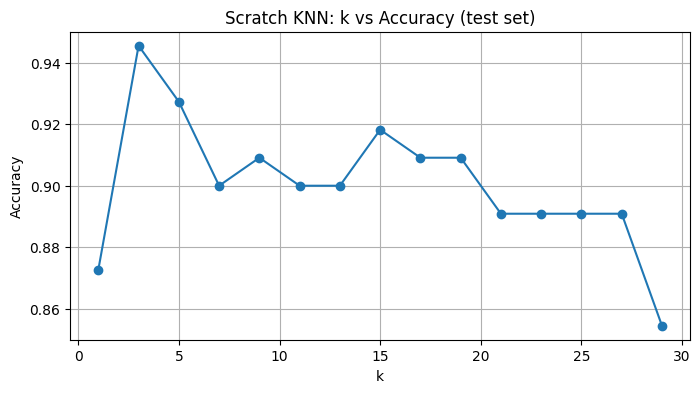

- Table of k values and accuracies (copy the printed table).
- Best k (from this test set sweep): 3
- Corresponding accuracy: 0.9454545454545454


In [ ]:
# Sweep odd k values and record accuracy on test set
max_k = min(31, X_train.shape[0]-1)
ks = list(range(1, max_k, 2))
scores = []
for k_try in ks:
    preds_k = scratch_knn_predict_full(X_train, y_train, X_test, k=k_try, use_weighted=False)
    scores.append(accuracy_score(y_test, preds_k))

# Print results in a compact table
print("k, accuracy")
for kv, sc in zip(ks, scores):
    print(f"{kv:2d} , {sc:.6f}")

best_k = ks[np.argmax(scores)]
best_acc = max(scores)
print(f"\nBest k from tested odd values: k={best_k} with accuracy={best_acc:.6f}")

# Plot (visual)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(ks, scores, marker='o')
plt.title('Scratch KNN: k vs Accuracy (test set)')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

print("- Table of k values and accuracies (copy the printed table).")
print("- Best k (from this test set sweep):", best_k)
print("- Corresponding accuracy:", best_acc)


Running 5-fold CV on training set for k values: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]


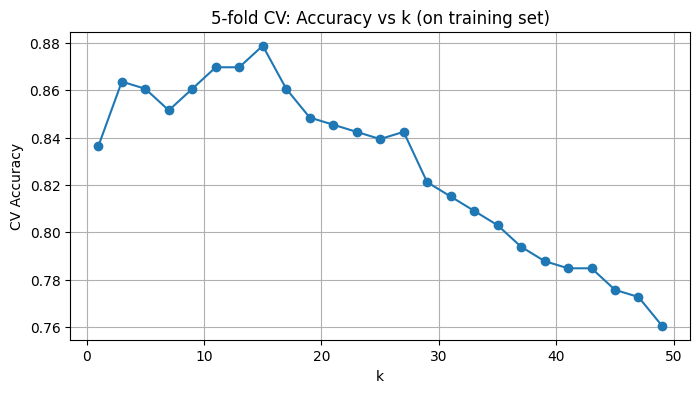


BEST k by 5-fold CV on training data: k = 15 with CV accuracy = 0.878788
NOTE — what to record:
- k_values tried: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]
- CV accuracies (list): [np.float64(0.836364), np.float64(0.863636), np.float64(0.860606), np.float64(0.851515), np.float64(0.860606), np.float64(0.869697), np.float64(0.869697), np.float64(0.878788), np.float64(0.860606), np.float64(0.848485), np.float64(0.845455), np.float64(0.842424), np.float64(0.839394), np.float64(0.842424), np.float64(0.821212), np.float64(0.815152), np.float64(0.809091), np.float64(0.80303), np.float64(0.793939), np.float64(0.787879), np.float64(0.784848), np.float64(0.784848), np.float64(0.775758), np.float64(0.772727), np.float64(0.760606)]
- Best k from CV (best_k_cv): 15
- Best CV mean accuracy: 0.878788

Evaluate final model (trained with best_k_cv) on the TEST set:
Test set accuracy: 0.936364
Confusion matrix:
 [[19  0  3]
 [ 2 42  1]
 [ 1  0 42]]


In [45]:
# Find best k using cross-validation on the TRAINING set, then evaluate that k on the TEST set.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ensure X_train, X_test, y_train, y_test exist
assert 'X_train' in globals() and 'X_test' in globals() and 'y_train' in globals() and 'y_test' in globals(), \
       "Run the preprocessing and train/test split cells first."

# Define k values to test (odd numbers to reduce tie frequency)
max_k = min(51, X_train.shape[0]-1)         # cap so we don't try absurdly large k
k_values = list(range(1, max_k, 2))

cv_scores = []
print("Running 5-fold CV on training set for k values:", k_values)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform', n_jobs=-1)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())

# Pick best k by CV (highest mean CV accuracy)
best_k_cv = k_values[np.argmax(cv_scores)]
best_cv_score = max(cv_scores)

# Plot CV curve
plt.figure(figsize=(8,4))
plt.plot(k_values, cv_scores, marker='o')
plt.title('5-fold CV: Accuracy vs k (on training set)')
plt.xlabel('k')
plt.ylabel('CV Accuracy')
plt.grid(True)
plt.show()

print(f"\nBEST k by 5-fold CV on training data: k = {best_k_cv} with CV accuracy = {best_cv_score:.6f}")
print("NOTE — what to record:")
print("- k_values tried:", k_values)
print("- CV accuracies (list):", [round(v,6) for v in cv_scores])
print("- Best k from CV (best_k_cv):", best_k_cv)
print("- Best CV mean accuracy:", round(best_cv_score,6))

# Retrain on full training set with best_k_cv and evaluate once on test set
final_knn = KNeighborsClassifier(n_neighbors=best_k_cv, weights='uniform', n_jobs=-1)
final_knn.fit(X_train, y_train)
y_test_pred = final_knn.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print("\nEvaluate final model (trained with best_k_cv) on the TEST set:")
print("Test set accuracy:", round(test_acc,6))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification report:\n", classification_report(y_test, y_test_pred))

print("\nNOTE — what to record for final evaluation:")
print("- Final chosen k (from CV):", best_k_cv)
print("- CV mean accuracy (for chosen k):", round(best_cv_score,6))
print("- Final test accuracy (unbiased):", round(test_acc,6))


**Visualize a test point and its neighbors (bar + PCA scatter) and record observations**

Neighbors for test index 0
1. train_idx=98 distance=0.165257 label=3
2. train_idx=53 distance=0.287649 label=3
3. train_idx=276 distance=0.296552 label=3
4. train_idx=198 distance=0.299878 label=3
5. train_idx=309 distance=0.311213 label=3
6. train_idx=296 distance=0.333146 label=3
7. train_idx=194 distance=0.354221 label=3


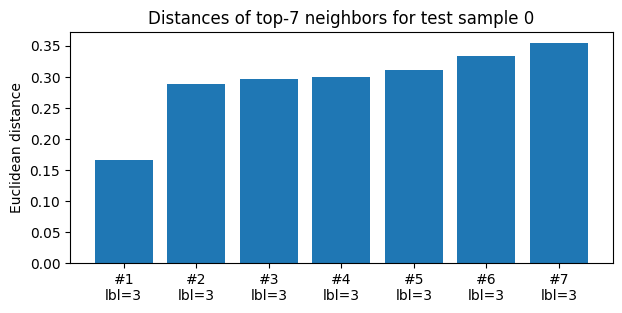

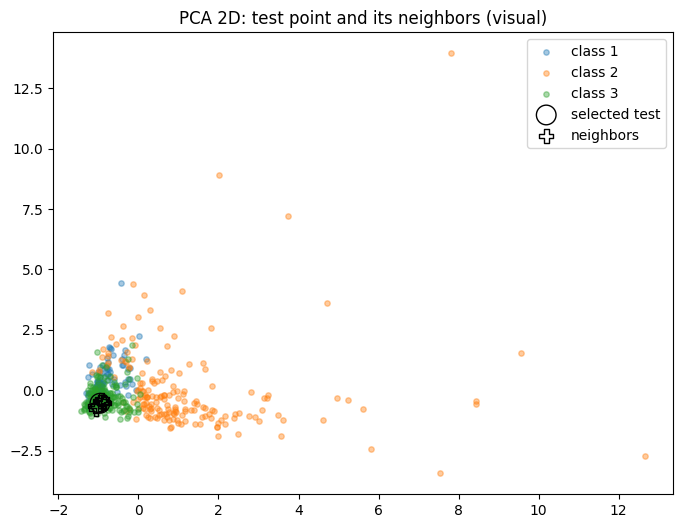

- For the chosen test point (index in X_test): list neighbor (train_idx, distance, label) printed above.
- Visual observation: Do neighbors cluster with same-class points in PCA scatter? (write Yes/No and a short sentence).


In [ ]:
# Choose a test sample to visualize neighbors (index relative to X_test)
visual_test_idx = 0
k_vis = 7

# Compute neighbor indices within training set and distances
dists = np.linalg.norm(X_train - X_test[visual_test_idx], axis=1)
idxs_sorted = np.argsort(dists)
neigh_idxs = idxs_sorted[:k_vis]
neigh_dists = dists[neigh_idxs]
neigh_labels = y_train[neigh_idxs]

print("Neighbors for test index", visual_test_idx)
for rank, (idx, d, lab) in enumerate(zip(neigh_idxs, neigh_dists, neigh_labels), start=1):
    print(f"{rank}. train_idx={idx} distance={d:.6f} label={lab}")

# Bar plot of distances
plt.figure(figsize=(7,3))
plt.bar(range(1, k_vis+1), neigh_dists)
plt.xticks(range(1, k_vis+1), [f"#{i}\nlbl={neigh_labels[i-1]}" for i in range(1,k_vis+1)])
plt.ylabel('Euclidean distance')
plt.title(f'Distances of top-{k_vis} neighbors for test sample {visual_test_idx}')
plt.show()

# PCA scatter plotting (global)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)  # entire dataset
# map to global indices: compute train/test split indices used earlier
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_idx_global, test_idx_global in sss.split(X, y):
    pass

global_test_idx = test_idx_global[visual_test_idx]
neighbor_global_idxs = train_idx_global[neigh_idxs]

plt.figure(figsize=(8,6))
# scatter all points (small)
for cls in np.unique(y):
    mask = (y == cls)
    plt.scatter(X_pca[mask,0], X_pca[mask,1], s=15, alpha=0.4, label=f'class {cls}')
# highlight test point and neighbors
plt.scatter(X_pca[global_test_idx,0], X_pca[global_test_idx,1], s=200, facecolors='none', edgecolors='k', label='selected test')
plt.scatter(X_pca[neighbor_global_idxs,0], X_pca[neighbor_global_idxs,1], s=100, marker='P', edgecolors='k', label='neighbors', facecolors='none')
plt.title('PCA 2D: test point and its neighbors (visual)')
plt.legend()
plt.show()

print("- For the chosen test point (index in X_test): list neighbor (train_idx, distance, label) printed above.")
print("- Visual observation: Do neighbors cluster with same-class points in PCA scatter? (write Yes/No and a short sentence).")


Performing 5-fold CV on training set to find best (k, weight).
 Searching weights = 'uniform' ...
 Searching weights = 'distance' ...


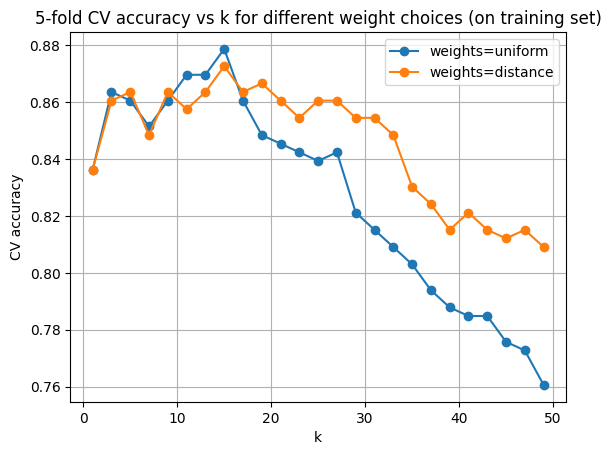


Best found by CV: k = 15, weight = 'uniform', CV accuracy = 0.878788

FINAL EVALUATION ON TEST SET
 - Best k (from CV): 15
 - Best weight (from CV): uniform
 - Test accuracy: 0.936364

Confusion matrix:
 [[19  0  3]
 [ 2 42  1]
 [ 1  0 42]]

Classification report:
               precision    recall  f1-score   support

           1       0.86      0.86      0.86        22
           2       1.00      0.93      0.97        45
           3       0.91      0.98      0.94        43

    accuracy                           0.94       110
   macro avg       0.93      0.92      0.92       110
weighted avg       0.94      0.94      0.94       110


Comparison (same k=15) - other weight='distance': test accuracy = 0.936364

NOTE — what to record:
 - k_values tried (odd values): [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]
 - weight options tried: ['uniform', 'distance']
 - Best k by CV (best_k_cv): 15
 - Best weight by CV (best_weight_cv): unif

In [46]:
# Sklearn KNN: find best (k, weight) by CV on TRAIN set (if not already found), retrain, and evaluate on TEST set.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Ensure data present
assert 'X_train' in globals() and 'X_test' in globals() and 'y_train' in globals() and 'y_test' in globals(), \
       "Run preprocessing and train/test split cells first."

# If best_k_cv / best_weight_cv already computed earlier, we re-use them.
# Otherwise do a grid search via CV over k_values and two weight options.
k_values = list(range(1, min(51, X_train.shape[0]-1), 2))  # odd ks: 1,3,5,... up to 49 or train_size-1
weight_options = ['uniform', 'distance']

# If best_k_cv and best_weight_cv exist, skip search; otherwise compute CV.
if 'best_k_cv' in globals() and 'best_weight_cv' in globals():
    print("Using existing best_k_cv and best_weight_cv from notebook variables.")
    print("best_k_cv =", best_k_cv, "best_weight_cv =", best_weight_cv)
    best_k = best_k_cv
    best_weight = best_weight_cv
else:
    print("Performing 5-fold CV on training set to find best (k, weight).")
    cv_results = {}  # (k,weight) -> mean_cv_score
    for weight in weight_options:
        scores_for_weight = []
        print(f" Searching weights = '{weight}' ...")
        for k in k_values:
            knn = KNeighborsClassifier(n_neighbors=k, weights=weight, n_jobs=-1)
            scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
            mean_score = scores.mean()
            cv_results[(k, weight)] = mean_score
            scores_for_weight.append(mean_score)
        # optional per-weight plot
        plt.plot(k_values, scores_for_weight, marker='o', label=f'weights={weight}')
    plt.title('5-fold CV accuracy vs k for different weight choices (on training set)')
    plt.xlabel('k')
    plt.ylabel('CV accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

    # pick best (k, weight)
    (best_k, best_weight), best_cv_score = max(cv_results.items(), key=lambda x: x[1])
    best_k_cv = best_k
    best_weight_cv = best_weight
    print(f"\nBest found by CV: k = {best_k_cv}, weight = '{best_weight_cv}', CV accuracy = {best_cv_score:.6f}")

# Retrain final model on full training set with best params and evaluate on test set
final_knn = KNeighborsClassifier(n_neighbors=int(best_k), weights=best_weight, n_jobs=-1)
final_knn.fit(X_train, y_train)
y_test_pred = final_knn.predict(X_test)

test_acc = accuracy_score(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred)

print("\nFINAL EVALUATION ON TEST SET")
print(f" - Best k (from CV): {best_k}")
print(f" - Best weight (from CV): {best_weight}")
print(f" - Test accuracy: {test_acc:.6f}")
print("\nConfusion matrix:\n", cm)
print("\nClassification report:\n", report)

# Also compute sklearn KNN with the other weight (same k) to compare (optional)
other_weight = 'distance' if best_weight == 'uniform' else 'uniform'
knn_other = KNeighborsClassifier(n_neighbors=int(best_k), weights=other_weight, n_jobs=-1)
knn_other.fit(X_train, y_train)
y_pred_other = knn_other.predict(X_test)
acc_other = accuracy_score(y_test, y_pred_other)
print(f"\nComparison (same k={best_k}) - other weight='{other_weight}': test accuracy = {acc_other:.6f}")

print("\nNOTE — what to record:")
print(f" - k_values tried (odd values): {k_values}")
print(f" - weight options tried: {weight_options}")
print(f" - Best k by CV (best_k_cv): {best_k}")
print(f" - Best weight by CV (best_weight_cv): {best_weight}")
print(f" - CV mean accuracy for chosen (k,weight): {best_cv_score:.6f}")
print(f" - Final test accuracy (trained on full train, evaluated once on test): {test_acc:.6f}")
print(" - Confusion matrix (copy above)")
print(" - Classification report (copy above)")
print(f" - Comparison with other weight (same k): other weight = '{other_weight}', test accuracy = {acc_other:.6f}")

# Save best params into globals for later cells (so you can re-use)
best_k_cv = best_k
best_weight_cv = best_weight
acc_final_test = test_acc


**sklearn KNN: fit & compare with scratch KNN — print metrics + notes to record**

In [ ]:
# Use best_k from scratch sweep if available, otherwise default to 5
sk_k = int(best_k) if 'best_k' in globals() else 5
print("Using k for sklearn KNN:", sk_k)

# Uniform weights
knn_uni = KNeighborsClassifier(n_neighbors=sk_k, weights='uniform')
knn_uni.fit(X_train, y_train)
y_pred_uni = knn_uni.predict(X_test)
acc_uni = accuracy_score(y_test, y_pred_uni)

# Distance weights
knn_dist = KNeighborsClassifier(n_neighbors=sk_k, weights='distance')
knn_dist.fit(X_train, y_train)
y_pred_dist = knn_dist.predict(X_test)
acc_dist = accuracy_score(y_test, y_pred_dist)

print(f"\nSklearn KNN (uniform) accuracy: {acc_uni:.6f}")
print("Confusion matrix (uniform):")
print(confusion_matrix(y_test, y_pred_uni))
print("\nClassification report (uniform):")
print(classification_report(y_test, y_pred_uni))

print(f"\nSklearn KNN (distance) accuracy: {acc_dist:.6f}")
print("Confusion matrix (distance):")
print(confusion_matrix(y_test, y_pred_dist))
print("\nClassification report (distance):")
print(classification_report(y_test, y_pred_dist))

print("\nCOMPARE with scratch KNN (unweighted) results above:")
if 'acc_scratch' in globals():
    print("- Scratch KNN accuracy (unweighted, same k):", acc_scratch)
else:
    print("- Scratch KNN result not found in this session (run scratch cells first).")

print("- sklearn KNN (uniform) accuracy:", acc_uni)
print("- sklearn KNN (uniform) confusion matrix and classification report (copy above).")
print("- sklearn KNN (distance) accuracy:", acc_dist)
print("- sklearn KNN (distance) confusion matrix and classification report (copy above).")
print("- If sklearn uniform accuracy == scratch accuracy (for same k and tie-breaker rules), note that they match; otherwise explain differences (tie-breaking or weighting).")


Using k for sklearn KNN: 3

Sklearn KNN (uniform) accuracy: 0.954545
Confusion matrix (uniform):
[[20  0  2]
 [ 2 43  0]
 [ 1  0 42]]

Classification report (uniform):
              precision    recall  f1-score   support

           1       0.87      0.91      0.89        22
           2       1.00      0.96      0.98        45
           3       0.95      0.98      0.97        43

    accuracy                           0.95       110
   macro avg       0.94      0.95      0.94       110
weighted avg       0.96      0.95      0.96       110


Sklearn KNN (distance) accuracy: 0.936364
Confusion matrix (distance):
[[19  0  3]
 [ 2 42  1]
 [ 0  1 42]]

Classification report (distance):
              precision    recall  f1-score   support

           1       0.90      0.86      0.88        22
           2       0.98      0.93      0.95        45
           3       0.91      0.98      0.94        43

    accuracy                           0.94       110
   macro avg       0.93      0.92  

**KNN observations**

In [ ]:
# Auto-fill the KNN observations template using variables from the current notebook.
# Run this cell after you've executed preprocessing, scratch KNN and sklearn KNN cells.

from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import json, textwrap

def safe_get(name, default=None):
    return globals().get(name, default)

# Basic dataset / preprocessing values
df_local = safe_get('df', None)
TARGET = safe_get('TARGET', None)
num_cols = safe_get('num_cols', [])
cat_cols = safe_get('cat_cols', [])
target_encoder = safe_get('target_encoder', None)
encoders = safe_get('encoders', {})

# Train/test and labels
X_train = safe_get('X_train', None)
X_test  = safe_get('X_test', None)
y_train = safe_get('y_train', None)
y_test  = safe_get('y_test', None)

# Scratch and sklearn results (may or may not exist)
k_full = safe_get('k_full', None)
acc_scratch = safe_get('acc_scratch', None)
best_k = safe_get('best_k', None)
best_acc = safe_get('best_acc', None)

sk_k = safe_get('sk_k', None)
acc_uni = safe_get('acc_uni', None)
acc_dist = safe_get('acc_dist', None)

y_pred_scratch = safe_get('y_pred_scratch', None)
y_pred_uni = safe_get('y_pred_uni', None)
y_pred_dist = safe_get('y_pred_dist', None)

# Demo neighbor indices if available
test_idx_demo = safe_get('test_idx_demo', None)
visual_test_idx = safe_get('visual_test_idx', None)
k_demo = safe_get('k_demo', None)
k_vis = safe_get('k_vis', None)

# Helper to compute report/matrix if predictions exist or can be recomputed
def compute_metrics(y_true, y_pred):
    try:
        acc = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred).tolist()
        report = classification_report(y_true, y_pred, output_dict=True)
    except Exception as e:
        acc, cm, report = None, None, None
    return acc, cm, report

# Try to recompute scratch predictions if missing but scratch function exists
if y_pred_scratch is None and 'scratch_knn_predict_full' in globals() and X_train is not None:
    try:
        k_try = k_full if k_full is not None else (best_k if best_k is not None else 5)
        y_pred_scratch = scratch_knn_predict_full(X_train, y_train, X_test, k=k_try, use_weighted=False)
        acc_scratch = accuracy_score(y_test, y_pred_scratch)
    except Exception as e:
        y_pred_scratch = None

# Try to recompute sklearn predictions if missing but model objects exist
if y_pred_uni is None and 'knn_uni' in globals():
    try:
        y_pred_uni = knn_uni.predict(X_test)
        acc_uni = accuracy_score(y_test, y_pred_uni)
    except Exception:
        pass
if y_pred_dist is None and 'knn_dist' in globals():
    try:
        y_pred_dist = knn_dist.predict(X_test)
        acc_dist = accuracy_score(y_test, y_pred_dist)
    except Exception:
        pass

# Collect metrics into text-friendly forms
scratch_acc_text = f"{acc_scratch:.6f}" if acc_scratch is not None else "N/A"
uni_acc_text = f"{acc_uni:.6f}" if acc_uni is not None else "N/A"
dist_acc_text = f"{acc_dist:.6f}" if acc_dist is not None else "N/A"

scratch_cm = None
scratch_report = None
if y_pred_scratch is not None:
    scratch_acc, scratch_cm, scratch_report = compute_metrics(y_test, y_pred_scratch)
    if scratch_acc is not None:
        scratch_acc_text = f"{scratch_acc:.6f}"

uni_cm = None
uni_report = None
if y_pred_uni is not None:
    uni_acc, uni_cm, uni_report = compute_metrics(y_test, y_pred_uni)
    if uni_acc is not None:
        uni_acc_text = f"{uni_acc:.6f}"

dist_cm = None
dist_report = None
if y_pred_dist is not None:
    dist_acc, dist_cm, dist_report = compute_metrics(y_test, y_pred_dist)
    if dist_acc is not None:
        dist_acc_text = f"{dist_acc:.6f}"

# Try to assemble demo neighbor lists if possible
demo_neighbors_text = ""
def build_neighbors_for_index(idx_in_Xtest, k_val=5):
    if X_train is None or X_test is None or y_train is None:
        return "Not available (missing X_train/X_test/y_train in the environment)\n"
    idx = int(idx_in_Xtest)
    dists_all = np.linalg.norm(X_train - X_test[idx], axis=1)
    sorted_idx = np.argsort(dists_all)
    top_idxs = sorted_idx[:k_val]
    lines = []
    for rank,(ti,d) in enumerate(zip(top_idxs, dists_all[top_idxs]), start=1):
        lab = int(y_train[ti]) if y_train is not None else "NA"
        lines.append(f"{rank}. train_idx={ti} distance={d:.6f} label={lab}")
    return "\n".join(lines)

if test_idx_demo is not None:
    kd = k_demo if k_demo is not None else 5
    demo_neighbors_text += f"Demo test sample (index in X_test): {test_idx_demo}\n"
    demo_neighbors_text += build_neighbors_for_index(test_idx_demo, kd) + "\n\n"

if visual_test_idx is not None and demo_neighbors_text == "":
    kv = k_vis if k_vis is not None else 7
    demo_neighbors_text += f"Visual test sample (index in X_test): {visual_test_idx}\n"
    demo_neighbors_text += build_neighbors_for_index(visual_test_idx, kv) + "\n\n"

# Compose final text
lines = []
lines.append("KNN Experiment Observations (AUTOFILLED)\n")
lines.append("="*60 + "\n\n")
# 1 Dataset
if df_local is not None:
    lines.append("1) Dataset:\n")
    lines.append(f" - Shape: {df_local.shape}\n")
    lines.append(f" - Columns: {list(df_local.columns)}\n")
    lines.append(f" - Target column used: {TARGET}\n\n")
else:
    lines.append("1) Dataset: NOT FOUND in environment (variable 'df' missing)\n\n")

# 2 Preprocessing
lines.append("2) Preprocessing:\n")
lines.append(f" - Numeric columns filled by mean (if any): {num_cols}\n")
lines.append(f" - Categorical columns filled by mode and label-encoded: {cat_cols}\n")
if encoders:
    lines.append(" - Categorical mappings (first 6 columns shown):\n")
    for i,(c,m) in enumerate(encoders.items()):
        if i>=6: break
        try:
            mapping = dict(zip(m.classes_, m.transform(m.classes_)))
            lines.append(f"    * {c}: {mapping}\n")
        except Exception:
            lines.append(f"    * {c}: mapping not accessible\n")
else:
    lines.append(" - No categorical encoders found (variable 'encoders' empty or missing)\n")
if target_encoder is not None:
    try:
        tmap = dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))
        lines.append(f" - Target mapping: {tmap}\n")
    except Exception:
        lines.append(" - Target mapping present but could not be serialized\n")
lines.append("\n")

# 3 Train/Test split
lines.append("3) Train/Test split:\n")
if X_train is not None and X_test is not None:
    lines.append(f" - Train samples: {X_train.shape[0]}\n")
    lines.append(f" - Test samples:  {X_test.shape[0]}\n")
else:
    lines.append(" - Train/Test arrays not found or not allocated in variables X_train/X_test\n")
if y_train is not None and y_test is not None:
    lines.append(f" - Train label counts: {dict(Counter(y_train))}\n")
    lines.append(f" - Test label counts:  {dict(Counter(y_test))}\n")
else:
    lines.append(" - y_train / y_test not available\n")
lines.append("\n")

# 4 Scratch KNN results
lines.append("4) Scratch KNN results (from notebook variables or recomputed):\n")
lines.append(f" - Example k used (k_full): {k_full}\n")
lines.append(f" - Scratch KNN accuracy: {scratch_acc_text}\n")
if scratch_cm is not None:
    lines.append(f" - Scratch confusion matrix:\n{json.dumps(scratch_cm)}\n")
if scratch_report is not None:
    lines.append(" - Scratch classification report (per-class metrics):\n")
    lines.append(json.dumps(scratch_report, indent=2))
lines.append("\n")

# 5 sklearn KNN results
lines.append("5) sklearn KNN results:\n")
lines.append(f" - sklearn KNN (uniform) accuracy (k={sk_k}): {uni_acc_text}\n")
if uni_cm is not None:
    lines.append(f" - sklearn (uniform) confusion matrix:\n{json.dumps(uni_cm)}\n")
if uni_report is not None:
    lines.append(" - sklearn (uniform) classification report:\n")
    lines.append(json.dumps(uni_report, indent=2))
lines.append(f"\n - sklearn KNN (distance-weighted) accuracy (k={sk_k}): {dist_acc_text}\n")
if dist_cm is not None:
    lines.append(f" - sklearn (distance) confusion matrix:\n{json.dumps(dist_cm)}\n")
if dist_report is not None:
    lines.append(" - sklearn (distance) classification report:\n")
    lines.append(json.dumps(dist_report, indent=2))
lines.append("\n")

# 6) k tuning sweep summary (if available)
lines.append("6) k sweep summary (best k found on test set if sweep run):\n")
lines.append(f" - best_k (from scratch sweep): {best_k}\n")
lines.append(f" - best_acc (from scratch sweep): {best_acc}\n\n")

# 7) Example neighbor lists (for debugging / explanation)
lines.append("7) Example Neighbor Lists (for one or two demo test points):\n")
if demo_neighbors_text:
    lines.append(demo_neighbors_text + "\n")
else:
    lines.append(" - No demo neighbor indices were available (run demo cells with 'test_idx_demo' or 'visual_test_idx').\n\n")

# 8) PCA / Visual observations placeholder
lines.append("8) PCA and visual observations (fill after looking at PCA plot):\n")
lines.append(" - Observation: (e.g., 'classes cluster well' or 'overlap near boundary')\n\n")

# 9) Final conclusions & recommendations
lines.append("9) Conclusions & recommendations:\n")
lines.append(" - (Write your conclusions here, e.g., whether KNN performed well, recommended k, notes about scaling or feature encoding.)\n\n")

# Save file
outfn = 'knn_observations_filled.txt'
with open(outfn, 'w') as f:
    f.write("\n".join(lines))

# Print summary to notebook for quick review
print("="*60)
print("AUTOFILLED KNN OBSERVATIONS saved to:", outfn)
print("="*60)
print("\nQuick summary:")
print(f" - Dataset shape: {df_local.shape if df_local is not None else 'N/A'}")
print(f" - Target column: {TARGET}")
print(f" - Train/test samples: {X_train.shape if X_train is not None else 'N/A'} / {X_test.shape if X_test is not None else 'N/A'}")
print(f" - Scratch KNN accuracy: {scratch_acc_text}")
print(f" - sklearn uniform accuracy: {uni_acc_text}")
print(f" - sklearn distance accuracy: {dist_acc_text}")
print("\nYou can open or download the file 'knn_observations_filled.txt' from the Colab left sidebar or run:")
print(f" !cat {outfn}  # to preview here")

# Also display first 4000 chars of the file for quick inspection
with open(outfn, 'r') as f:
    preview = f.read(4000)
print("\n===== File preview =====\n")
print(preview)


AUTOFILLED KNN OBSERVATIONS saved to: knn_observations_filled.txt

Quick summary:
 - Dataset shape: (440, 8)
 - Target column: class
 - Train/test samples: (330, 7) / (110, 7)
 - Scratch KNN accuracy: 0.927273
 - sklearn uniform accuracy: 0.954545
 - sklearn distance accuracy: 0.936364

You can open or download the file 'knn_observations_filled.txt' from the Colab left sidebar or run:
 !cat knn_observations_filled.txt  # to preview here

===== File preview =====

KNN Experiment Observations (AUTOFILLED)



1) Dataset:

 - Shape: (440, 8)

 - Columns: ['Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen', 'class']

 - Target column used: class


2) Preprocessing:

 - Numeric columns filled by mean (if any): ['Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

 - Categorical columns filled by mode and label-encoded: []

 - No categorical encoders found (variable 'encoders' empty or missing)



3) Train/Test split:

 - Train sampl